# AOS AuxTel test data : repeatability

Setup:

    ssh -L 54467:localhost:54467 scichris@lsst-devl02
    source "/software/lsstsw/stack/loadLSST.bash"
    setup lsst_distrib
    source /project/scichris/aos/setup_aos_current.sh
    jupyter notebook --no-browser --port=54467

Use data from Tiago : `210707` "HD 83745" ,  Sequence of intra/extra pairs without changing the hexapod position

    #1CWFS=462-472
    #2CWFS=473-475
    #3CWFS=476-478
    #4CWFS=479-481
    #5CWFS=482-484
    #6CWFS=485-487
    #7CWFS=488-490
    #8CWFS=491-493
    #9CWFS=494-496
    #10CWFS=497-499

Run the ISR:
    
    ssh lsst-devl02

    source "/software/lsstsw/stack/loadLSST.bash"
    setup lsst_distrib

https://pipelines.lsst.io/v/weekly/modules/lsst.daf.butler/queries.html#dimension-expressions

    pipetask run  --data-query "exposure IN (2021070700462..2021070700499) AND instrument='LATISS' " -b /repo/main/butler.yaml --input  LATISS/raw/all,LATISS/calib,u/czw/DM-28920/calib.20210720  --output u/scichris/Latiss/postISRtest --pipeline /project/scichris/aos/testLatiss4.yaml  --register-dataset-types
    

In [2]:
%matplotlib inline
from astropy.io import fits
from astropy.visualization import ZScaleInterval
import matplotlib.pyplot as plt
import numpy as np 
from lsst.daf import butler as dafButler


def preview_auxtel_exposures(year='2021', monthDay='0908', expStart=483, expEnd=490,
                            datasetRefOrType='raw', collection='LATISS/raw/all'):

    butler = dafButler.Butler('/repo/main/')
    
    # figure out how many images to plot
    nexp = expEnd-expStart

    # calculate how many cols and rows we need 
    if nexp > 3:
        ncol = 3
        nrows = (nexp // ncol) + 1
    else:
        ncol=nexp
        nrows = 1
        
    zscale = ZScaleInterval()
    # do the plotting 
    fig,axs = plt.subplots(nrows,ncol,figsize=(ncol*4,nrows*4))
    ax = np.ravel(axs)
    i=0
    for exp in range(expStart,expEnd):
        exposure = butler.get(datasetRefOrType, dataId={'instrument':'LATISS', 'detector':0, 
                                         'exposure':int(f'{year}{monthDay}00{exp}')
                                            },
                          collections=[collection])
        data = exposure.image.array
        vmin, vmax = zscale.get_limits(data)
        ax[i].imshow(data,vmin=vmin,vmax=vmax,origin=
                  'lower')
        ax[i].set_title(f"{year}{monthDay}, exp {exp},\n focusz={np.round(exposure.getMetadata()['FOCUSZ'],3)}")
        i += 1
    fig.subplots_adjust(hspace=0.25)

    # if there are more axes than exposures,
    # turn off the extra axes 
    ncells = nrows*ncol
    if ncells > nexp:
        for axis in ax[nexp:]:
            axis.axis("off")

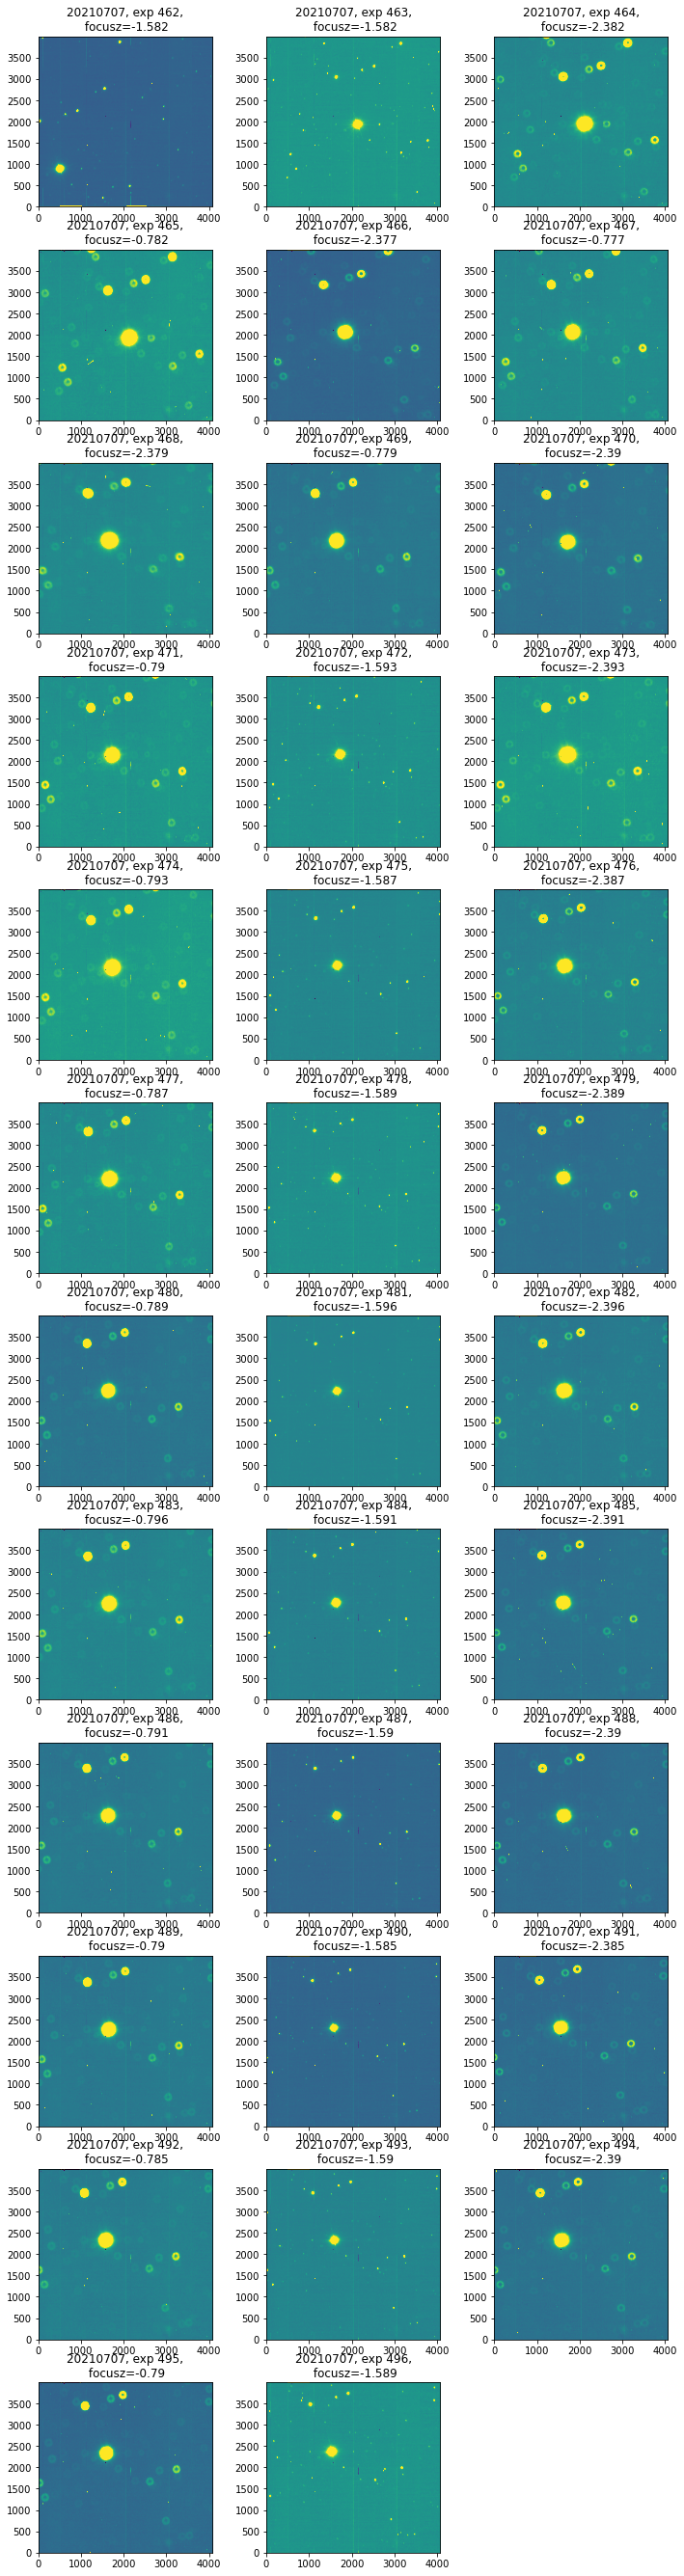

In [4]:
#2021 - 07 - 07
preview_auxtel_exposures(year='2021',monthDay='0707', 
                         expStart=462, expEnd=497,
                         datasetRefOrType='postISRCCD', 
                         collection='u/scichris/Latiss/postISRtest')

From the above construct intra/extra pairs to pass to the ZernikeEstimate task:

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from lsst.ts.wep.Utility import DefocalType
from copy import copy
from lsst.ts.wep.DonutDetector import DonutDetector
from lsst.daf import butler as dafButler

def fit_zernikes(estimateZernikeTask, exp=307,year='2021', monthDay='0323',
                datasetRefOrType='postISRCCD', collection='u/scichris/Latiss/postISRtest',):

    butler = dafButler.Butler('/repo/main/')
    
    # load the exposure pair 
    exposure_intra = butler.get(datasetRefOrType, dataId={'instrument':'LATISS', 'detector':0, 
                                             'exposure':int(f'{year}{monthDay}00{exp}')
                                                }, collections=[collection])

    exposure_extra = butler.get(datasetRefOrType, dataId={'instrument':'LATISS', 'detector':0, 
                                             'exposure':int(f'{year}{monthDay}00{exp+1}')
                                                }, collections=[collection])

    # declare the exposure pair
    exposure_pair = [exposure_intra, exposure_extra ]

    print(f'\nRunning Zk fitting for exposure={exp}')


    # get the  template from estimateZernikeTask. 

    detectorName = exposure_extra.getDetector().getName()
    pixelScale = exposure_extra.getWcs().getPixelScale().asArcseconds()
    defocalType = DefocalType.Extra
    template = estimateZernikeTask.getTemplate(detectorName, defocalType, pixelScale)

    # detect donuts  in one of the defocal images 
    detector = DonutDetector()
    expArray = copy(exposure_extra.getImage().getArray())

    # use the adaptive threshold finding algorithm for the binary image 
    donutDf = detector.detectDonuts(expArray, template, blendRadius=200,
                                       peakThreshold=0.99, binaryChoice = 'deblend')
    np.save(f'donuts_{year}{monthDay}00{exp}.npy', donutDf)

    # make a donut catalog :
    ## remove the blends in donut catalog 
    donutDfClean = donutDf[~donutDf['blended']].copy()

    ## update column names and content 
    donutCatUpd = update_donut_cat(donutDfClean.copy(), exposure_intra)

    # run zernike estimation
    zernikeOutput = estimateZernikeTask.run(exposure_pair, donutCatUpd, "LATISS")

    # store zernikes as dict
    zernikes = zernikeOutput.getDict()
    fname = f'zerDic_{year}{monthDay}00{exp}.npy'
    np.save(fname,zernikes)
    print(f'Stored the results as {fname} ')
    
def update_donut_cat(donutCat, exposure):
    
    ## rename columns, as the EstimateZernikes  expects different names:
    ## coord_ra; coord_dec; centroid_x; centroid_y; source_flux; detector; mags
    
    
    # and add a detector column 
    donutCat['detector'] = exposure.getDetector().getName()

    # rename columns: transpose y --> x 
    donutCat = donutCat.rename(columns={"y_center":"centroid_x", "x_center":"centroid_y"})
    
    # pass whatever ra,dec to the catalog - they're not used, but are required to be there 
    wcs = exposure.getWcs()
    x = np.array(donutCat['centroid_x'].values)
    y = np.array(donutCat['centroid_y'].values)

    x = np.zeros(0)
    for row in donutCat['centroid_x'] : 
        x = np.append(x, row)

    ra,dec = wcs.pixelToSkyArray(x,y,degrees=False)  
    
    donutCat['coord_ra'] = ra
    donutCat['coord_dec'] = dec
    return donutCat

In [2]:
# initialize the zernike Task - has to be done only once 
from lsst.ts.wep.task.EstimateZernikesLatissTask import EstimateZernikesLatissTask, EstimateZernikesLatissTaskConfig
estimateZernikeConfig = EstimateZernikesLatissTaskConfig(donutStampSize=200,donutTemplateSize=200)
estimateZernikeTask = EstimateZernikesLatissTask(config=estimateZernikeConfig)
estimateZernikeTask.instName = 'auxTel'
estimateZernikeTask.opticalModel = 'onAxis'

expIntra = [464, 466, 468, 470, 473, 476, 479, 482, 485, 488, 491, 494]
#expExtra = np.array(expIntra)+1
for exp in expIntra:
    fit_zernikes(estimateZernikeTask, exp=exp,
                 year='2021', monthDay='0707',)

/project/scichris/aos/ts_wep/python/lsst/ts/wep/task/EstimateZernikesBase.py:442: FutureWarning: Call to deprecated function (or staticmethod) timeMethod. (timeMethod has been replaced by lsst.utils.timer.timeMethod. Will be removed after v25.) -- Deprecated since version v24.
  def estimateZernikes(self, donutStampsExtra, donutStampsIntra):



Running Zk fitting for exposure=464
In DonutTemplateModel using opticalModel onAxis
and maskScalingFactorLocal=2.0
Using deblendAdapt _getImgBinaryAdapt to get image binary
In DonutTemplateModel using opticalModel onAxis
and maskScalingFactorLocal=2.0
In DonutTemplateModel using opticalModel onAxis
and maskScalingFactorLocal=2.0
0 / 5
imageCoCenter: (x, y) = (   98.63,  100.88)

imageCoCenter: (x, y) = (  101.22,  100.88)

itr = 0, z4-z22
[  -8.  -33. -164.  229.  108.   -7.  -27.  -11.   27.    7.   -6.   -2.
  -19.  -44.    3.    2.   -4.    2.    5.]
itr = 1, z4-z22
[ -14.  -35. -159.  231.  109.   -7.  -26.  -10.   27.    7.   -6.   -2.
  -18.  -45.    3.    2.   -4.    2.    5.]
itr = 2, z4-z22
[ -12.  -29. -163.  229.  109.   -7.  -27.  -11.   27.    6.   -6.   -2.
  -18.  -44.    3.    2.   -4.    2.    5.]
itr = 3, z4-z22
[ -17.  -46. -225.  230.  109.   -8.  -27.  -10.   25.    7.   -6.   -3.
  -19.  -45.    4.    3.   -4.    1.    5.]
itr = 4, z4-z22
[ -20.  -55. -273.  228.

itr = 12, z4-z22
[  15.   57. -105.   57.  -15.   27.  -55.  -22.   17.    7.   -3.   -3.
   26.   11.   -1.   -2.   -3.  -10.    7.]
itr = 13, z4-z22
[ 20.  64. -99.  56. -12.  25. -60. -22.  17.   6.  -4.  -4.  26.  12.
  -1.  -2.  -3. -11.   7.]
itr = 14, z4-z22
[ 32.  55. -98.  41. -23.  26. -66. -25.  18.  10.  -4.  -4.  30.  16.
  -1.  -3.  -4. -13.   7.]
4 / 5
imageCoCenter: (x, y) = (   99.54,  102.01)

imageCoCenter: (x, y) = (  100.82,  101.09)

itr = 0, z4-z22
[ 10.   3. -72.  75.  27.  -1.  -8.  -4.  11.  -0.  -0.  -1.  -4. -13.
   1.   0.   0.   0.   1.]
itr = 1, z4-z22
[ 13.  -0. -70.  79.  27.  -1.  -8.  -4.  10.  -0.  -0.  -1.  -4. -14.
   1.   0.   0.   0.   1.]
itr = 2, z4-z22
[ 17.   1. -71.  77.  27.  -1.  -8.  -4.  10.  -0.  -0.  -1.  -4. -14.
   1.   0.   1.   0.   1.]
itr = 3, z4-z22
[  21.    2. -107.   77.   27.   -2.   -8.   -4.   10.   -0.   -0.   -1.
   -4.  -14.    1.    0.    0.    0.    1.]
itr = 4, z4-z22
[  24.    1. -140.   77.   27.   -2.   -8.   -4. 

itr = 10, z4-z22
[ -28.   62. -123.   34.    6.    2.  -17.  -13.    3.    1.   -7.   -7.
    3.   -3.   -1.   -1.    6.   -2.    3.]
itr = 11, z4-z22
[ -25.   65. -127.   34.    4.    0.  -20.  -13.    3.    1.   -8.   -9.
    4.   -3.   -1.   -1.    7.   -3.    4.]
itr = 12, z4-z22
[ -21.   69. -130.   34.    3.   -1.  -22.  -13.    3.    1.  -10.  -11.
    5.   -3.   -1.   -1.    8.   -3.    4.]
itr = 13, z4-z22
[ -17.   73. -133.   34.    0.   -3.  -24.  -14.    3.    1.  -11.  -12.
    5.   -3.   -1.   -1.   10.   -3.    4.]
itr = 14, z4-z22
[ -14.   75. -136.   34.    1.   -4.  -25.  -14.    3.    1.  -12.  -13.
    5.   -3.   -1.   -1.   11.   -4.    4.]
3 / 4
imageCoCenter: (x, y) = (   99.29,  101.22)

imageCoCenter: (x, y) = (   98.96,  102.26)

itr = 0, z4-z22
[  4.   7. -53.  50.  11.  -2.   3.  -3.   6.  -1.  -2.  -4.  -0. -10.
  -1.  -0.   2.  -1.   1.]
itr = 1, z4-z22
[  6.   6. -52.  51.  12.  -2.   4.  -3.   6.  -1.  -2.  -4.  -1. -11.
  -1.  -0.   2.  -1.   1.]
itr = 

itr = 8, z4-z22
[ -39.  -69.  123.  174. -165. -401. -369.    2.   -4.    6.  -20.   -0.
   28.  -40.   38.   38.   36.  -22.    1.]
itr = 9, z4-z22
[ -36.  -46.  151.  166. -204. -346. -305.    1.   -9.    1.  -29.    0.
   40.  -36.   35.   35.   59.  -36.    1.]
itr = 10, z4-z22
[ -34.  -55.  149.  158. -231. -301. -257.    0.   -8.    2.  -39.    1.
   47.  -34.   33.   33.   82.  -51.    2.]
itr = 11, z4-z22
[ -30.  -58.  152.  164. -245. -261. -212.   -0.   -8.    2.  -48.    1.
   51.  -34.   33.   32.  104.  -67.    2.]
itr = 12, z4-z22
[ -26.  -55.  159.  182. -254. -225. -168.   -1.   -8.    2.  -56.    1.
   54.  -38.   32.   32.  128.  -86.    2.]
itr = 13, z4-z22
[ -21.  -51.  165.  198. -262. -186. -125.   -2.   -8.    2.  -63.    1.
   57.  -41.   31.   32.  152. -105.    3.]
itr = 14, z4-z22
[ -18.  -56.  163.  193. -274. -145.  -84.   -3.   -6.    3.  -71.    1.
   60.  -39.   31.   31.  175. -124.    3.]
3 / 4
imageCoCenter: (x, y) = (   99.16,  101.42)

imageCoCenter

itr = 7, z4-z22
[ -27.   84. -123.    8.   26.   -3.  -64.   -5.    7.  -14.    3.   -5.
    2.    0.    4.    0.    2.   -2.    2.]
itr = 8, z4-z22
[ -32.   73. -125.   10.   30.   -3.  -72.   -6.    7.  -15.    3.   -5.
    1.   -1.    4.    0.    2.   -2.    2.]
itr = 9, z4-z22
[ -28.   62. -125.   10.   26.   -2.  -68.   -6.    7.  -15.    4.   -7.
    2.   -1.    4.    0.    3.   -2.    2.]
itr = 10, z4-z22
[ -24.   52. -126.   10.   24.   -2.  -65.   -7.    7.  -15.    5.   -9.
    3.   -0.    4.    0.    3.   -3.    2.]
itr = 11, z4-z22
[ -19.   44. -127.    9.   22.   -2.  -63.   -7.    7.  -15.    7.  -10.
    3.   -0.    4.    1.    4.   -4.    3.]
itr = 12, z4-z22
[ -15.   36. -127.    9.   22.   -2.  -60.   -7.    7.  -15.    7.  -11.
    4.   -0.    4.    0.    5.   -5.    3.]
itr = 13, z4-z22
[ -12.   29. -127.   10.   21.   -1.  -58.   -7.    7.  -15.    8.  -13.
    4.   -0.    4.    0.    5.   -5.    3.]
itr = 14, z4-z22
[  -9.   22. -128.   10.   22.   -1.  -56.   -7.

itr = 4, z4-z22
[  28.  -40. -188.   21.   -6.   -3.  -15.  -10.   16.    6.   -7.    4.
    3.   -4.    1.    1.   -0.    1.    3.]
itr = 5, z4-z22
[  21.  -29. -170.    5.   -1.   -4.  -21.  -14.   15.    5.   -7.    4.
    1.    2.    1.    1.    0.    1.    4.]
itr = 6, z4-z22
[  10.  -22. -160.   11.   -3.   -5.  -26.  -18.   14.    5.   -7.    5.
    1.   -0.    1.    1.    0.    1.    4.]
itr = 7, z4-z22
[  -2.  -16. -152.    9.   -2.   -6.  -31.  -20.   14.    5.   -7.    5.
    1.    1.    0.    1.    0.    1.    4.]
itr = 8, z4-z22
[ -14.  -11. -146.   10.   -2.   -7.  -34.  -23.   14.    5.   -7.    5.
    1.    0.    0.    1.    0.    1.    4.]
itr = 9, z4-z22
[  -9.   -7. -140.    9.   -5.   -5.  -36.  -24.   14.    5.  -10.    7.
    2.    1.    0.    1.    0.    2.    5.]
itr = 10, z4-z22
[  -4.   -4. -135.    8.   -6.   -4.  -38.  -25.   14.    5.  -13.    9.
    2.    1.    0.    1.    0.    2.    5.]
itr = 11, z4-z22
[   1.   -0. -131.    8.   -7.   -3.  -40.  -26.   

itr = 1, z4-z22
[  -4.  145.  416.  -51. -370.   58.   72.  -31. -111.  -24.   -6.    4.
   75.   14.  -20.  -14.  -30.   17.   11.]
itr = 2, z4-z22
[  19.  124.  452.  -41. -352.   59.  110.  -32. -114.  -21.    9.   -0.
   69.   12.  -30.  -14.  -39.   13.    9.]
itr = 3, z4-z22
[  63.  116.  643.  -21. -247.   43.  177.  -27.  -90.  -10.   79.   -4.
   51.    6.  -39.  -12.  -32.    3.    4.]
itr = 4, z4-z22
[  95.  117.  781.  -19. -204.   29.  191.  -24.  -72.   -5.  102.   -2.
   48.    5.  -37.   -9.  -20.    0.    3.]
itr = 5, z4-z22
[ 96. 116. 713.  -5. -60.  41. 275. -33. -77.  -7.  80.  -2.  -6.   1.
 -36.  -7. -28.   4.   3.]
itr = 6, z4-z22
[  79.   98.  634.  -15. -110.   58.  341.  -39.  -76.   -6.   81.   -2.
   11.    4.  -31.   -8.  -28.    5.    5.]
itr = 7, z4-z22
[ 56.  84. 579. -11. -97.  69. 397. -44. -81.  -5.  75.  -2.   5.   2.
 -29.  -7. -31.   7.   6.]
itr = 8, z4-z22
[  25.   74.  520.  -15. -106.   82.  444.  -49.  -85.   -4.   71.   -1.
    6.    3.  -27.

itr = 0, z4-z22
[ -10.  -14. -134.   -2.   24.   -2.  -17.   -8.   23.    6.    0.   -4.
   -3.    0.    3.    1.    2.    3.    4.]
itr = 1, z4-z22
[ -14.  -14. -134.   -2.   23.   -2.  -17.   -8.   22.    6.    0.   -4.
   -4.    0.    3.    1.    3.    3.    4.]
itr = 2, z4-z22
[ -18.  -14. -134.   -2.   23.   -2.  -17.   -8.   22.    6.   -0.   -4.
   -4.    0.    3.    1.    3.    3.    4.]
itr = 3, z4-z22
[ -21.  -22. -190.   -2.   23.   -2.  -16.   -8.   21.    6.   -0.   -5.
   -3.    0.    3.    1.    3.    3.    4.]
itr = 4, z4-z22
[ -24.  -29. -236.   -2.   23.   -3.  -16.   -8.   20.    6.   -1.   -5.
   -4.    1.    3.    1.    3.    3.    4.]
itr = 5, z4-z22
[ -34.  -16. -214.    0.    6.   -4.  -23.  -11.   19.    6.   -1.   -5.
    2.   -0.    2.    1.    3.    2.    4.]
itr = 6, z4-z22
[ -44.   -7. -200.   -0.   12.   -5.  -29.  -14.   18.    5.   -1.   -5.
    0.    0.    2.    1.    3.    2.    4.]
itr = 7, z4-z22
[ -55.   -0. -191.   -0.   10.   -5.  -34.  -16.   18

itr = 14, z4-z22
[  62.   56. -233.  -10.  -47.    7.   88.  -29.   -6.   -5.  -49.   -7.
   26.    8.   -0.   -2.   35.    0.    5.]
2 / 4
imageCoCenter: (x, y) = (   99.49,   99.50)

imageCoCenter: (x, y) = (   99.49,   99.50)

itr = 0, z4-z22
[  14.  -26. -128.    1.  -19.   -8.  -14.  -10.   22.    6.   -1.   -5.
    4.    2.    0.    1.    2.    2.    2.]
itr = 1, z4-z22
[  21.  -26. -128.    1.  -20.   -8.  -13.  -10.   22.    7.   -1.   -5.
    4.    2.    0.    1.    2.    2.    2.]
itr = 2, z4-z22
[  26.  -26. -127.    3.  -19.   -8.  -13.  -10.   22.    6.   -1.   -5.
    4.    1.   -0.    1.    2.    2.    3.]
itr = 3, z4-z22
[  30.  -38. -182.    1.  -20.   -9.  -14.  -10.   21.    7.   -1.   -6.
    4.    1.    0.    1.    2.    2.    3.]
itr = 4, z4-z22
[  33.  -49. -227.    3.  -21.   -9.  -13.   -9.   20.    7.   -1.   -6.
    5.    1.   -0.    1.    2.    2.    3.]
itr = 5, z4-z22
[  27.  -36. -202.   -1.   -5.  -13.  -19.  -13.   19.    6.   -1.   -6.
   -1.    2.   -

itr = 11, z4-z22
[ -13.   35. -130.   -5.    4.  -16.  -22.  -19.   11.    9.   -2.   -5.
   -2.    2.   -2.    1.    1.    2.    5.]
itr = 12, z4-z22
[  -8.   40. -128.   -5.    4.  -16.  -25.  -19.   11.    9.   -2.   -6.
   -2.    2.   -2.    1.    1.    2.    5.]
itr = 13, z4-z22
[  -3.   44. -126.   -6.    4.  -15.  -28.  -19.   11.    9.   -2.   -6.
   -2.    2.   -2.    1.    2.    3.    5.]
itr = 14, z4-z22
[   1.   48. -124.   -6.    5.  -14.  -30.  -19.   11.    9.   -2.   -7.
   -2.    2.   -3.    1.    2.    3.    6.]
2 / 4
imageCoCenter: (x, y) = (  101.48,  100.84)

imageCoCenter: (x, y) = (   39.00,  115.00)

itr = 0, z4-z22
[  17.   19. -118.   -8.   28.  -15.  224.    7.   48.   -4.    5.   -8.
   -4.    1.  -52.    2.   -2.   -2.   -4.]
itr = 1, z4-z22
[  26.   16. -120.   -6.   31.  -13.  220.    7.   49.   -3.    6.   -9.
   -4.    1.  -50.    2.   -2.   -2.   -4.]
itr = 2, z4-z22
[  35.   26. -121.   -8.   33.  -17.  215.    7.   49.   -6.    9.   -7.
   -4.    1. 

itr = 8, z4-z22
[ -12.   12. -182.    6.  -13.   -9.  -77.  -21.   18.    2.    0.   -1.
    1.    1.    3.    0.    1.    4.    4.]
itr = 9, z4-z22
[  -7.   15. -174.    6.  -17.   -9.  -76.  -22.   18.    2.    0.   -2.
    3.    2.    3.   -0.    1.    5.    5.]
itr = 10, z4-z22
[  -3.   17. -167.    5.  -18.  -10.  -76.  -23.   18.    2.    1.   -2.
    3.    2.    3.   -0.    2.    7.    5.]
itr = 11, z4-z22
[   1.   19. -161.    4.  -19.  -11.  -76.  -23.   18.    2.    1.   -2.
    4.    2.    3.   -0.    2.    8.    5.]
itr = 12, z4-z22
[   5.   21. -156.    3.  -20.  -12.  -76.  -24.   18.    2.    1.   -3.
    4.    3.    3.   -0.    2.    9.    5.]
itr = 13, z4-z22
[   9.   23. -152.    3.  -20.  -12.  -76.  -24.   18.    2.    1.   -3.
    4.    3.    3.   -0.    3.   10.    6.]
itr = 14, z4-z22
[  13.   24. -149.   -1.  -20.  -13.  -77.  -24.   19.    2.    1.   -3.
    3.    4.    3.   -0.    3.   11.    6.]
2 / 4
imageCoCenter: (x, y) = (   27.50,   97.00)

imageCoCenter

itr = 5, z4-z22
[  16.   55. -156.    1.    2.   -7.  -14.  -12.   10.   -4.    0.   -4.
    2.    1.    1.    1.   -0.    0.    3.]
itr = 6, z4-z22
[   6.   53. -151.    4.    8.   -9.  -18.  -15.   10.   -4.    0.   -4.
   -1.    0.    1.    1.   -0.    1.    4.]
itr = 7, z4-z22
[  -6.   52. -149.    2.    5.  -11.  -22.  -17.   10.   -4.    0.   -4.
    0.    1.    1.    1.   -0.    1.    4.]
itr = 8, z4-z22
[ -18.   50. -148.    5.    6.  -13.  -25.  -19.   10.   -4.    0.   -4.
   -0.    1.    1.    1.   -0.    1.    4.]
itr = 9, z4-z22
[ -15.   49. -146.    2.    7.  -11.  -26.  -21.   10.   -4.    0.   -5.
   -0.    2.    1.    1.   -0.    1.    4.]
itr = 10, z4-z22
[ -12.   49. -145.    0.    6.  -10.  -27.  -22.   10.   -4.    0.   -7.
   -0.    2.    1.    1.   -0.    1.    5.]
itr = 11, z4-z22
[  -9.   49. -144.   -2.    6.   -9.  -28.  -22.   10.   -4.    0.   -9.
   -0.    3.    1.    1.   -0.    1.    5.]
itr = 12, z4-z22
[  -6.   48. -143.   -2.    6.   -8.  -29.  -23.  

itr = 2, z4-z22
[ 11.  -3. -88.  17.   0.  -9. -28.  -6.  13.   1.   1.  -3.   1.  -3.
   5.   1.   1.   3.   2.]
itr = 3, z4-z22
[  13.   -6. -128.   19.   -0.   -8.  -28.   -6.   13.    1.    1.   -3.
    1.   -4.    5.    1.    1.    3.    2.]
itr = 4, z4-z22
[  15.   -9. -163.   19.   -0.   -9.  -28.   -6.   12.    1.    1.   -3.
    1.   -4.    5.    1.    1.    3.    2.]
itr = 5, z4-z22
[  10.   -6. -153.    4.    0.  -13.  -41.   -9.   11.    1.    1.   -3.
    1.    1.    4.    1.    1.    3.    3.]
itr = 6, z4-z22
[   3.   -5. -149.   11.   -0.  -16.  -53.  -11.   11.    1.    1.   -3.
    1.   -1.    4.    1.    1.    3.    3.]
itr = 7, z4-z22
[  -6.   -4. -146.    8.    0.  -19.  -63.  -12.   11.    1.    1.   -3.
    1.    0.    4.    1.    1.    3.    3.]
itr = 8, z4-z22
[ -15.   -3. -144.    9.   -0.  -22.  -71.  -14.   11.    1.    1.   -3.
    1.   -0.    4.    1.    1.    3.    3.]
itr = 9, z4-z22
[ -10.   -2. -142.    9.   -1.  -23.  -70.  -14.   10.    1.    1.   -5.

Illustrate the results:

In [5]:
# plot the truth vs simulation... 
from lsst.daf import butler as dafButler
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from lsst.ts.wep.Utility import DefocalType
from lsst.ts.wep.DonutDetector import DonutDetector
from copy import copy
import yaml
from astropy.io import fits  
from astropy.visualization import ZScaleInterval

from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18


def plot_zernike_image(exp=464, year='2021',monthDay='0707'):

    # plot the figure ...   
    fig = plt.figure(figsize=(14, 5))

    ####################################
    ### left - plot the fit results  ###
    #################################### 

    #add_axes([xmin,ymin,dx,dy]) 
    ax1 = fig.add_axes([0,0,0.6,1])  

    #for exp in expIntra:
    zkResultsFile = f'zerDic_{year}{monthDay}00{exp}.npy'
    zkFit = np.load(zkResultsFile, allow_pickle=True).item()

    for i in range(len(zkFit['outputZernikesRaw'])):
        
        ax1.plot(np.arange(4, 23),1000*zkFit['outputZernikesRaw'][i], 
                 '-d', label=f'exp {exp}-{exp+1}')

    ax1.set_xlabel('Zernike Number',)
    ax1.set_ylabel('Zernike Coefficient [nanometers]', )
    ax1.legend(fontsize=14, loc='center left', bbox_to_anchor=[.65, 0.65])
    ax1.set_xticks(np.arange(4,23)[::2])
    ax1.grid()


    ax1.set_title(f'auxTel test data {year}{monthDay}', fontsize=18)


    ###############################################
    ### right - plot the postISR image ###
    ###############################################


    ax2 = fig.add_axes([0.6,0,0.4,1])
    butler = dafButler.Butler('/repo/main/')
    datasetRefOrType='postISRCCD'; collection='u/scichris/Latiss/postISRtest'
    exposure_intra = butler.get(datasetRefOrType, dataId={'instrument':'LATISS', 'detector':0, 
                                                 'exposure':int(f'{year}{monthDay}00{exp}')
                                                    }, collections=[collection])
    zscale = ZScaleInterval()
    data = exposure_intra.image.array
    vmin, vmax = zscale.get_limits(data)

    ax2.imshow(data, origin='lower', vmin=vmin, vmax=vmax)

    nrows = len(zkFit['donutStampsExtra'])
    for i in range(nrows):
        donut = zkFit['donutStampsExtra'][i]
        xy = donut.centroid_position

        # plot the cross marking that the donut was used 
        ax2.scatter(xy[0],xy[1],s=200,marker='+',c='m', lw=4)

        # plot the donut number on the plot 
        xtext,ytext = xy[0],xy[1]
        ytext -= 60
        if xtext+100 > 4096:
            xtext -= 250
        if len(str(i))>1: # move to the left label thats too long 
            #print(i, 'moving')
            xtext -=340 
        else:
            xtext -=260
        ax2.text(xtext, ytext, f'{i}', fontsize=17, c='white' )    
    ax2.yaxis.tick_right()
    ax2.set_xlabel('x [px]')
    ax2.set_ylabel('y [px]')
    ax2.yaxis.set_label_position("right")
    ax2.set_title(f'exp{exp}')

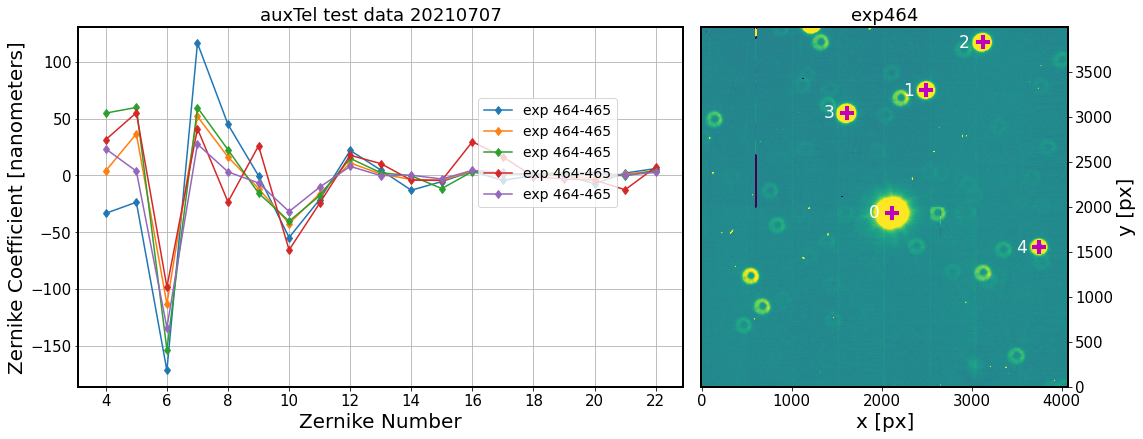

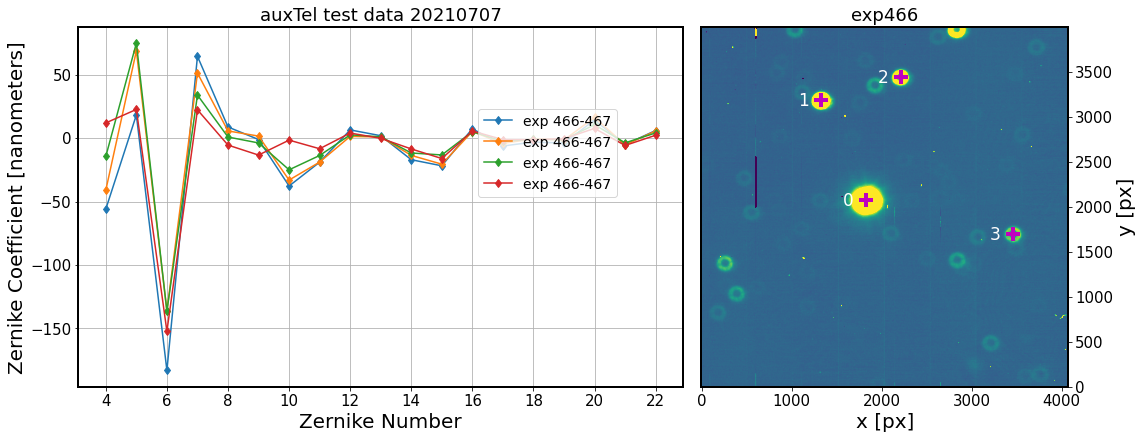

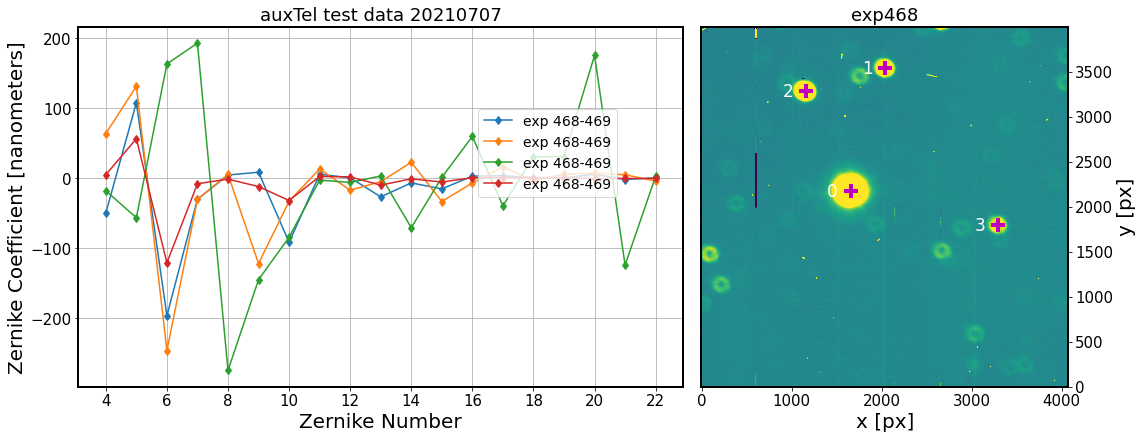

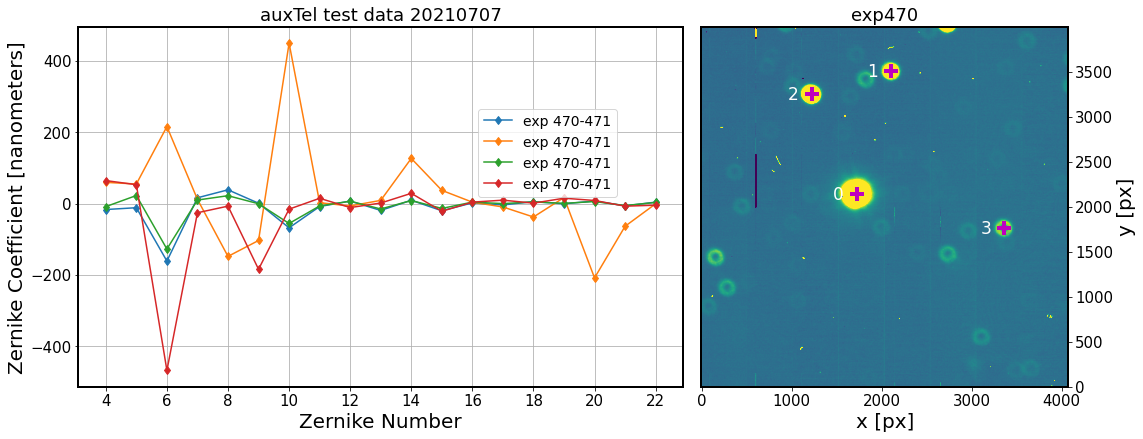

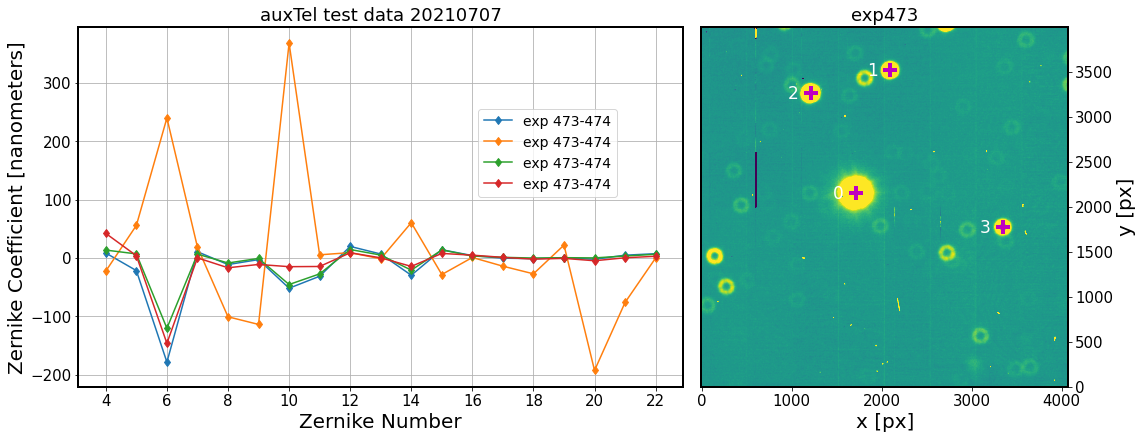

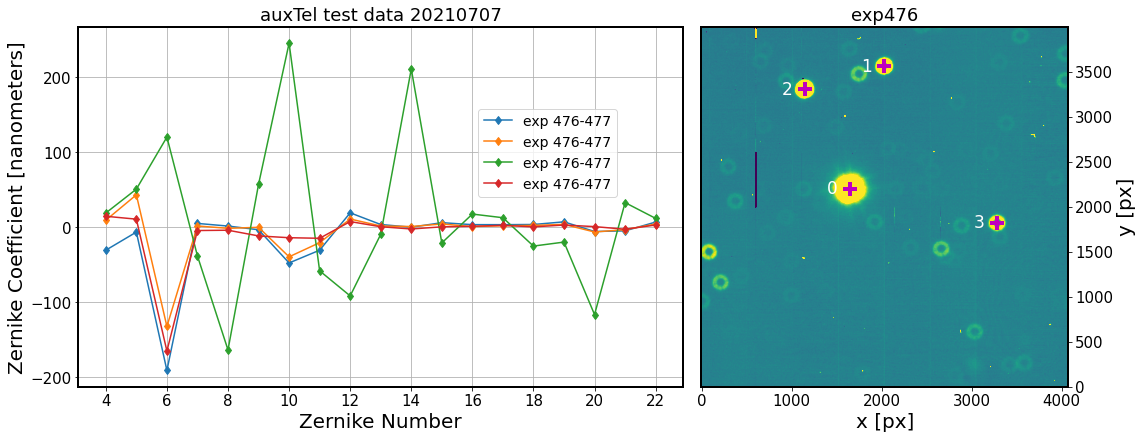

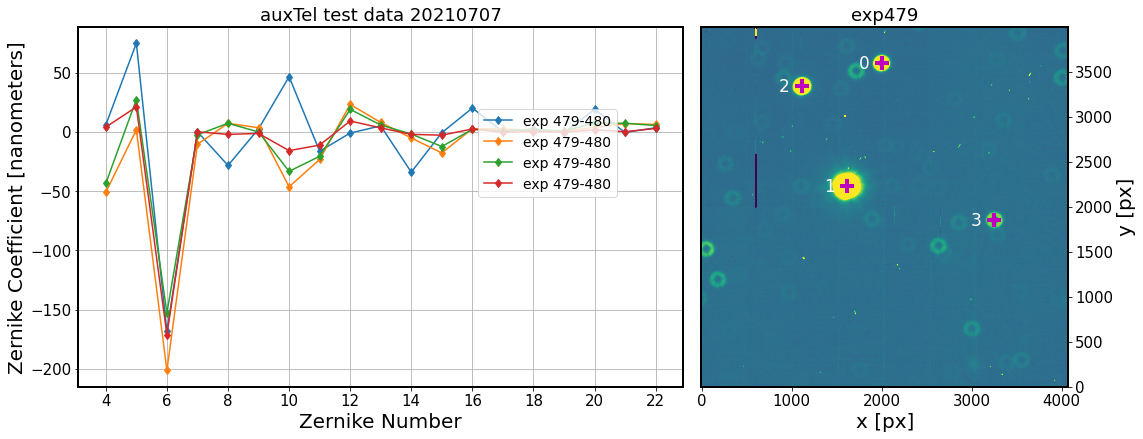

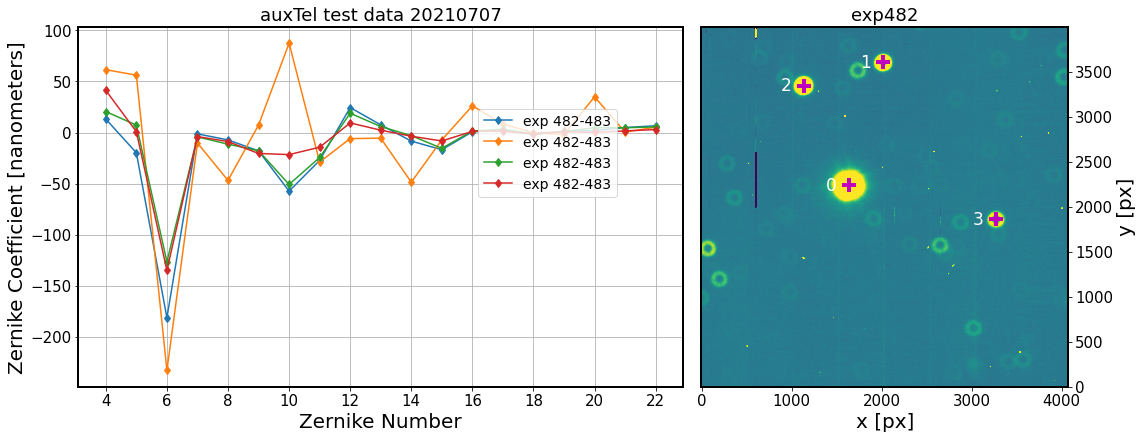

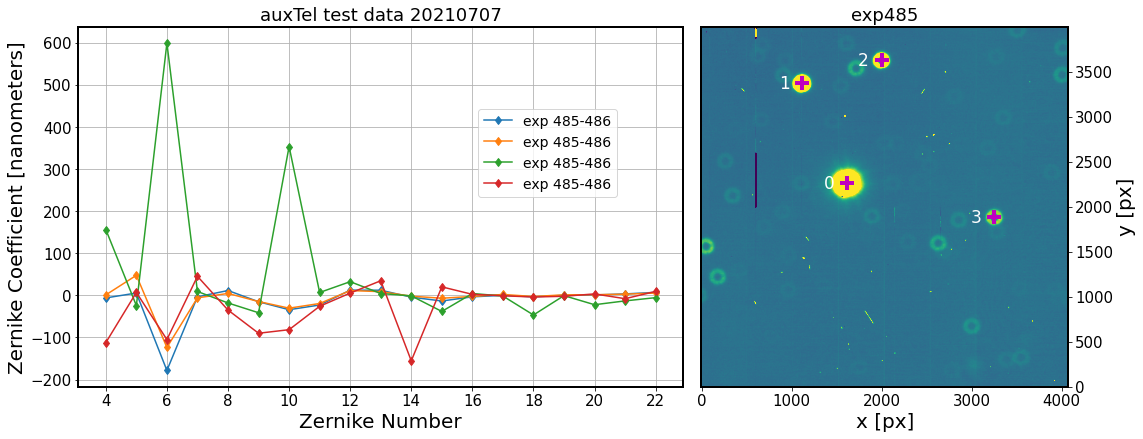

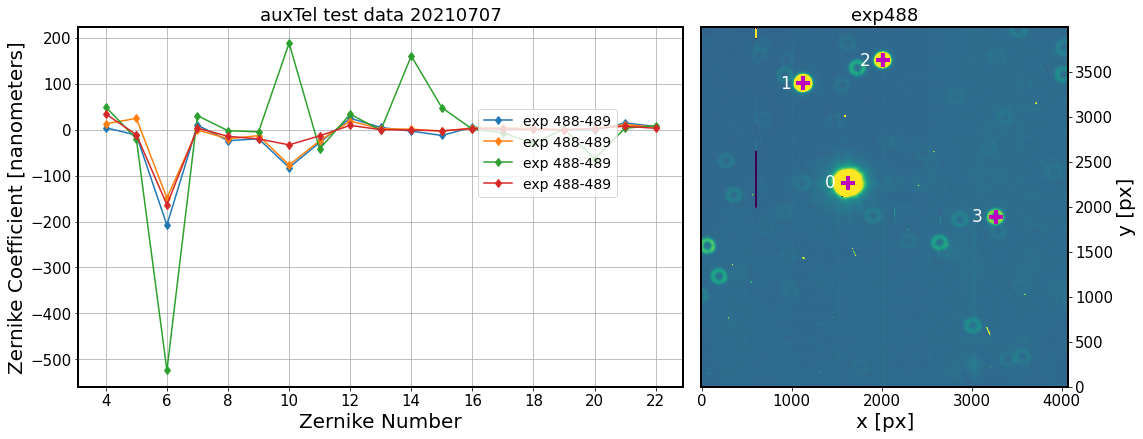

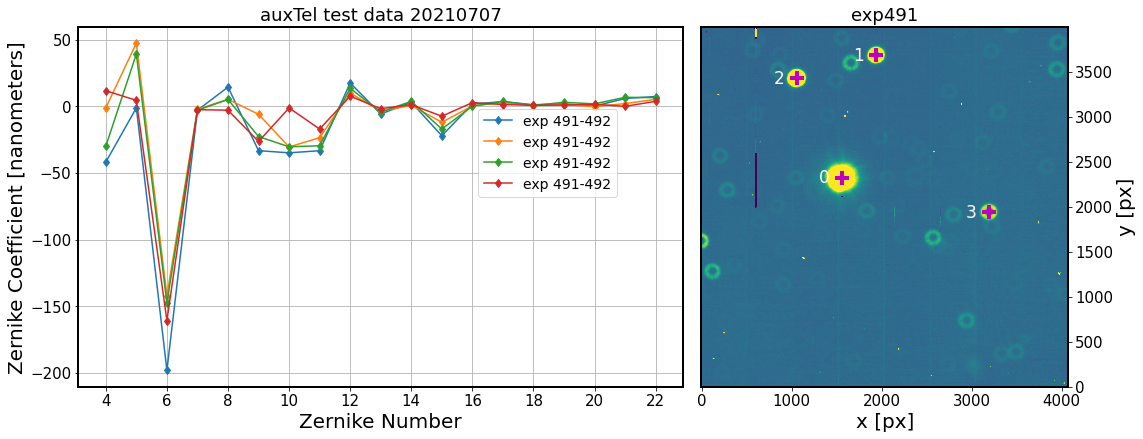

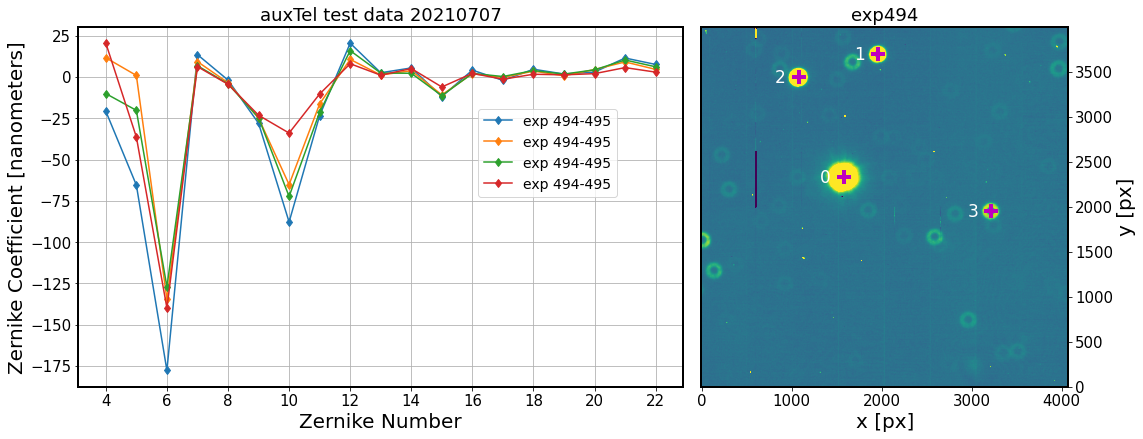

In [7]:


expIntra = [464, 466, 468, 470, 473, 476, 479, 482, 485, 488, 491, 494]
for exp in expIntra:
    plot_zernike_image(exp=exp, year='2021',monthDay='0707')

In [8]:
brightDonutId = {464:0,466:0,468:0, 470:0, 473:0, 476:0, 479:1, 482:0, 485:0, 488:0, 491:0, 494:0 }

Plot results only for the brightest star from across different exposures:

Problem - we don't really know which one is the brightest as no brightness measurement is done ... Perhaps try the WCS-fitting route? 

In [2]:
import numpy as np 
exp=464
year='2021'
monthDay='0707'
zkResultsFile = f'zerDic_{year}{monthDay}00{exp}.npy'
zkFit = np.load(zkResultsFile, allow_pickle=True).item()
# load the donut detection catalog 
# the problem is that it doesn't have any flux information,
# only x,y, whether blended, blends
donutDfFile = f'donuts_{year}{monthDay}00{exp}.npy'
donutDf  = np.load(donutDfFile, allow_pickle=True)

Ok, let me just manually set for each exposure pair the main donut that I am trying to compare across exposure pairs... The only other way would be to use the WCS information, or try to fit the donut detection catalog to a reference catalog based on the extra-focal exposure ra,dec, rotAng, and thus recover the true magnitudes of these objects...  But for these specific few exposures this seems the quickest way:

In [17]:
x

2115.0

In [18]:
y

1934.0

Text(0.5, 1.0, 'exp494')

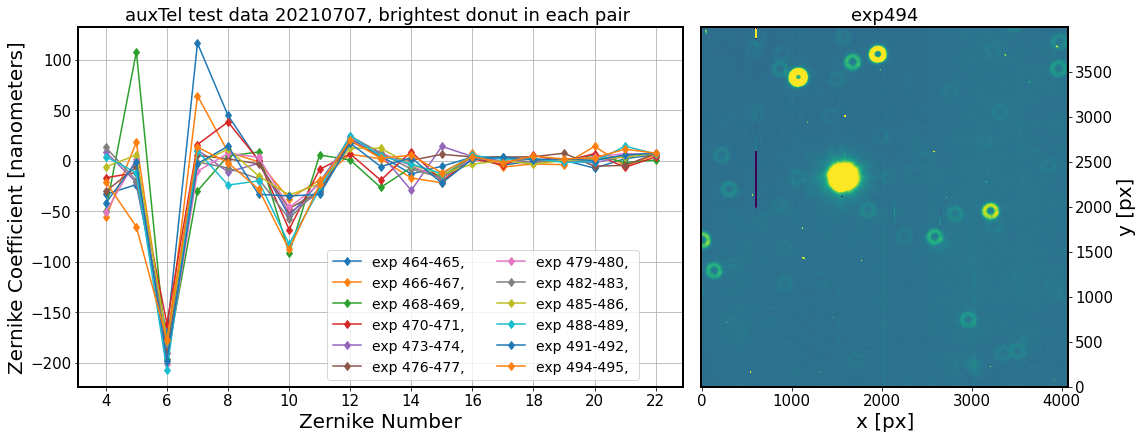

In [12]:
# plot the truth vs simulation... 
from lsst.daf import butler as dafButler
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from lsst.ts.wep.Utility import DefocalType
from lsst.ts.wep.DonutDetector import DonutDetector
from copy import copy
import yaml
from astropy.io import fits  
from astropy.visualization import ZScaleInterval

from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18



expIntra = [464, 466, 468, 470, 473, 476, 479, 482, 485, 488, 491, 494]
brightDonutId = {464:0, 466:0, 468:0, 470:0, 473:0, 476:0, 
                 479:1, 482:0, 485:0, 488:0, 491:0, 494:0 
                }


# plot the figure ...   
fig = plt.figure(figsize=(14, 5))

####################################
### left - plot the fit results  ###
#################################### 

#add_axes([xmin,ymin,dx,dy]) 
ax1 = fig.add_axes([0,0,0.6,1])  

for exp in expIntra:
    zkResultsFile = f'zerDic_{year}{monthDay}00{exp}.npy'
    zkFit = np.load(zkResultsFile, allow_pickle=True).item()

    #for i in range(len(zkFit['outputZernikesRaw'])):
    # figure out which donut to plot zernikes for 
    # based on the dictionary above
    donutId = brightDonutId[exp]
    #donut = zkFit['donutStampsExtra'][i]
    #x,y = donut.centroid_position
    # can't go by position matching because it chanmges from exposure pair to 
    # another exposure pair 
    #if (abs(x - 2115) < 20) and (abs(y-1934.0)<20):
    #   print('plotting', x,y)
    ax1.plot(np.arange(4, 23),1000*zkFit['outputZernikesRaw'][donutId], 
             '-d', label=f'exp {exp}-{exp+1}, ')

ax1.set_xlabel('Zernike Number',)
ax1.set_ylabel('Zernike Coefficient [nanometers]', )
ax1.legend(fontsize=14, loc='center left', bbox_to_anchor=[.4, 0.2],ncol=2)
ax1.set_xticks(np.arange(4,23)[::2])
ax1.grid()
ax1.set_title(f'auxTel test data {year}{monthDay}, brightest donut in each pair ', fontsize=18)


###############################################
### right - plot the postISR image ###
###############################################


ax2 = fig.add_axes([0.6,0,0.4,1])
butler = dafButler.Butler('/repo/main/')
datasetRefOrType='postISRCCD'; collection='u/scichris/Latiss/postISRtest'
exposure_intra = butler.get(datasetRefOrType, dataId={'instrument':'LATISS', 'detector':0, 
                                             'exposure':int(f'{year}{monthDay}00{exp}')
                                                }, collections=[collection])
zscale = ZScaleInterval()
data = exposure_intra.image.array
vmin, vmax = zscale.get_limits(data)

ax2.imshow(data, origin='lower', vmin=vmin, vmax=vmax)

#nrows = len(zkFit['donutStampsExtra'])
#for i in range(nrows):
    #donut = zkFit['donutStampsExtra'][donutId]
    #xy = donut.centroid_position

    # plot the cross marking that the donut was used 
    #ax2.scatter(xy[0],xy[1],s=200,marker='+',c='m', lw=4)

    # plot the donut number on the plot 
    #xtext,ytext = xy[0],xy[1]
    #ytext -= 60
#     if xtext+100 > 4096:
#         xtext -= 250
#     if len(str(i))>1: # move to the left label thats too long 
#         #print(i, 'moving')
#         xtext -=340 
#     else:
#         xtext -=260
#     ax2.text(xtext, ytext, f'{i}', fontsize=17, c='white' )    
ax2.yaxis.tick_right()
ax2.set_xlabel('x [px]')
ax2.set_ylabel('y [px]')
ax2.yaxis.set_label_position("right")
ax2.set_title(f'exp{exp}')

In [19]:
import galsim
import numpy as np
zDicAnnular = {}
zDicList4_37 = []
for j in range(4, 37):
    z = galsim.zernike.Zernike([0]*j+[1], R_inner=0.61)
    zkAnnular = np.sqrt(np.sum(z.gradX.coef**2) + np.sum(z.gradY.coef**2))
    zDicAnnular[j] =  zkAnnular
    zDicList4_37.append(zkAnnular)
    print(f"{j:>2}   {zkAnnular:>6.3f}")

 4    9.139
 5    3.302
 6    3.302
 7    9.971
 8    9.971
 9    4.818
10    4.818
11   20.436
12   11.406
13   11.406
14    6.286
15    6.286
16   21.359
17   21.359
18   13.259
19   13.259
20    7.729
21    7.729
22   34.196
23   22.748
24   22.748
25   15.374
26   15.374
27    9.158
28    9.158
29   35.220
30   35.220
31   24.523
32   24.523
33   17.645
34   17.645
35   10.580
36   10.580


In [21]:
len(zDicList4_37[:19])

19

In [23]:
rms = zDicList4_37[:19]

In [24]:
rms

[9.139196602279338,
 3.301526166168794,
 3.301526166168794,
 9.97064360614345,
 9.970643606143446,
 4.817513223742869,
 4.817513223742869,
 20.43586486243172,
 11.40553281059747,
 11.405532810597476,
 6.286099629011046,
 6.286099629011046,
 21.359491865251066,
 21.359491865251023,
 13.25857787595336,
 13.258577875953359,
 7.72855354839792,
 7.72855354839792,
 34.195742476097635]

Text(0.5, 1.0, 'exp494')

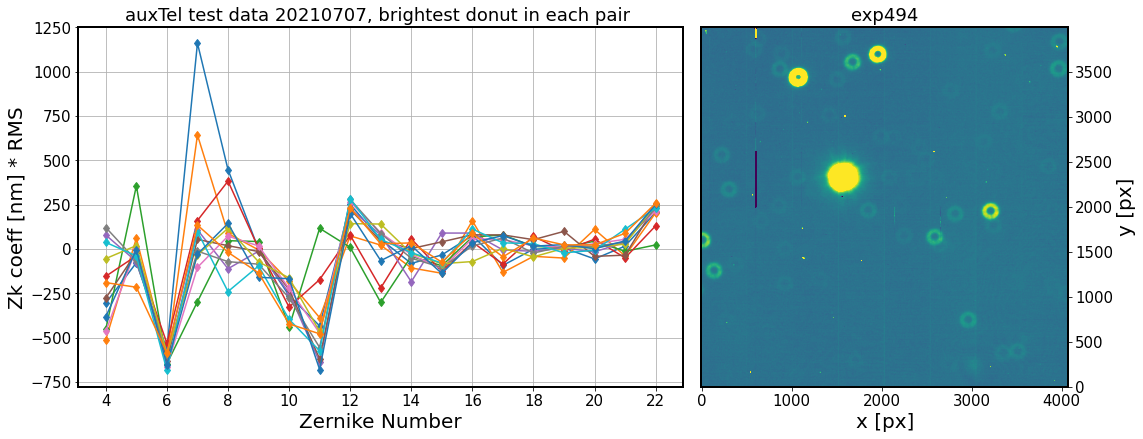

In [27]:
# plot the truth vs simulation... 
from lsst.daf import butler as dafButler
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from lsst.ts.wep.Utility import DefocalType
from lsst.ts.wep.DonutDetector import DonutDetector
from copy import copy
import yaml
from astropy.io import fits  
from astropy.visualization import ZScaleInterval

from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18



expIntra = [464, 466, 468, 470, 473, 476, 479, 482, 485, 488, 491, 494]
brightDonutId = {464:0, 466:0, 468:0, 470:0, 473:0, 476:0, 
                 479:1, 482:0, 485:0, 488:0, 491:0, 494:0 
                }

# plot the figure ...   
fig = plt.figure(figsize=(14, 5))

####################################
### left - plot the fit results  ###
#################################### 

#add_axes([xmin,ymin,dx,dy]) 
ax1 = fig.add_axes([0,0,0.6,1])  

for exp in expIntra:
    zkResultsFile = f'zerDic_{year}{monthDay}00{exp}.npy'
    zkFit = np.load(zkResultsFile, allow_pickle=True).item()

    donutId = brightDonutId[exp]
    zk  = 1000*zkFit['outputZernikesRaw'][donutId]
    rms = zDicList4_37[:19]
    ax1.plot(np.arange(4, 23),zk*rms, 
             '-d', label=f'exp {exp}-{exp+1}, ')

ax1.set_xlabel('Zernike Number',)
ax1.set_ylabel('Zk coeff [nm] * RMS', )
# ax1.legend(fontsize=14, loc='center left', bbox_to_anchor=[.4, 0.2],ncol=2)
ax1.set_xticks(np.arange(4,23)[::2])
ax1.grid()
ax1.set_title(f'auxTel test data {year}{monthDay}, brightest donut in each pair ', fontsize=18)


###############################################
### right - plot the postISR image ###
###############################################
ax2 = fig.add_axes([0.6,0,0.4,1])
butler = dafButler.Butler('/repo/main/')
datasetRefOrType='postISRCCD'; collection='u/scichris/Latiss/postISRtest'
exposure_intra = butler.get(datasetRefOrType, dataId={'instrument':'LATISS', 'detector':0, 
                                             'exposure':int(f'{year}{monthDay}00{exp}')
                                                }, collections=[collection])
zscale = ZScaleInterval()
data = exposure_intra.image.array
vmin, vmax = zscale.get_limits(data)

ax2.imshow(data, origin='lower', vmin=vmin, vmax=vmax)
 
ax2.yaxis.tick_right()
ax2.set_xlabel('x [px]')
ax2.set_ylabel('y [px]')
ax2.yaxis.set_label_position("right")
ax2.set_title(f'exp{exp}')